# Meta model

## Load required modules and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [2]:
import pickle

In [3]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

In [4]:
from sklearn.ensemble import StackingRegressor

### Settings

In [5]:
# default plt figuresize, smallish
plt.rcParams["figure.figsize"] = (6,3)

## Load and prepare the data

In [6]:
### Load dataset
data = datasets.data_original()
### Feature engineering 
data = features.engineer(data)
### Train test split (unprocessed)
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Scaling the data 

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_.columns)



## Load and evaluate all models

In [8]:
models = {}

### Logistic regression

In [9]:
models["Logistic"] = pickle.load(open("models/logistic_RFE9.pkl", "rb"))

c:\Users\User\Projects\DHcode\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
n_features = models["Logistic"].coef_.shape[1]
n_features

9

In [11]:
rfe_features = pickle.load(open("models/rfe_features_250103.pkl", "rb"))[9]

In [12]:
print(rfe_features)

['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored']


### Random Forest

In [13]:
with open("models/random_forest_gridsearch_241218.pkl", "rb") as file:
    models["RandomForest"] = pickle.load(file)

c:\Users\User\Projects\DHcode\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\Projects\DHcode\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### KNN ###

In [14]:
with open("models/knn.pkl", "rb") as file:
    models["Knearestneighbors"] = pickle.load(file)

c:\Users\User\Projects\DHcode\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### MLP

In [16]:
with open("models/neural_network_small_20012025.pkl", "rb") as file:
    neural_networks_small = pickle.load(file)

In [18]:
for hl in neural_networks_small:
    models["MultiLayerPerceptron_" + str(hl)] = neural_networks_small[hl]

In [20]:
print(neural_networks_small.keys())

dict_keys([(2,), (5,), (8, 2)])


## Evaluate the models

In [34]:

y_train = y_train_
y_test = y_test_

y_pred_train = {}
y_proba_train = {}

y_pred_test = {}
y_proba_test = {}

In [51]:
print(y_train.shape, y_test.shape)

(1711,) (428,)


### Data preprocessing

In [42]:
# by default we assing unscaled raw data to each model
X_train_preprocessed = {modelname: X_train_ for modelname in models}
X_test_preprocessed = {modelname: X_test_ for modelname in models}



In [43]:
# Logistic : scaled dataset, with only selected features
X_train_preprocessed["Logistic"] = X_train_scaled[rfe_features]
X_test_preprocessed["Logistic"] = X_test_scaled[rfe_features]


In [52]:
# MLP : scaled dataset
for modelname in X_train_preprocessed:
    if "MultiL" == modelname[:6]:
        X_train_preprocessed[modelname] = X_train_scaled
        X_test_preprocessed[modelname] = X_test_scaled

In [53]:
X_train_preprocessed.keys()

dict_keys(['Logistic', 'RandomForest', 'Knearestneighbors', 'MultiLayerPerceptron_(2,)', 'MultiLayerPerceptron_(5,)', 'MultiLayerPerceptron_(8, 2)'])

In [54]:
X_test_preprocessed.keys()

dict_keys(['Logistic', 'RandomForest', 'Knearestneighbors', 'MultiLayerPerceptron_(2,)', 'MultiLayerPerceptron_(5,)', 'MultiLayerPerceptron_(8, 2)'])

### Evaluate all models

In [55]:
for model_name in models:
    model = models[model_name]

    X_train = X_train_preprocessed[model_name]
    y_pred_train[model_name] = model.predict(X_train)
    y_proba_train[model_name] = model.predict_proba(X_train)[:,1]

    X_test = X_test_preprocessed[model_name]
    y_pred_test[model_name] = model.predict(X_test)
    y_proba_test[model_name] = model.predict_proba(X_test)[:,1]

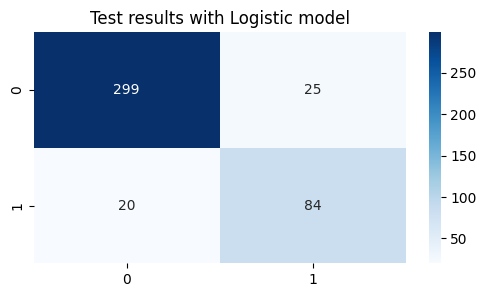

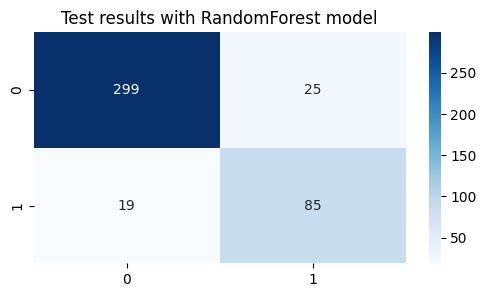

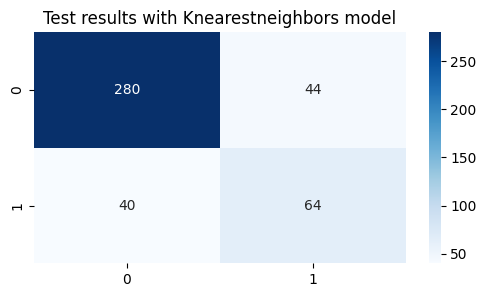

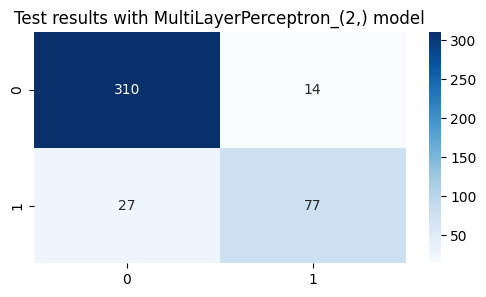

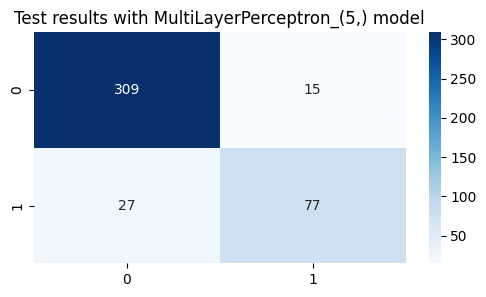

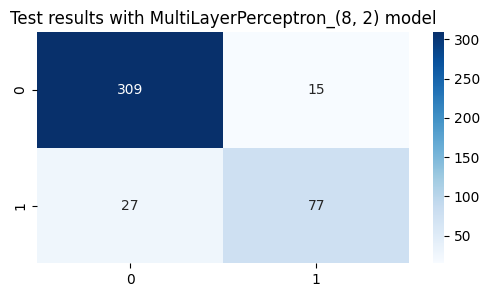

In [56]:
for model_name in models:
    sns.heatmap(confusion_matrix(y_test,y_pred_test[model_name]), annot = True, cmap = "Blues", fmt='d')
    plt.title("Test results with " + model_name + " model")
    plt.show()


### Evaluation scores


In [57]:
results_test_models_list = []

for model_name in models : 
    y_pred = y_pred_test[model_name]

    results_test = {
        "model": model_name,
        "accuracy": accuracy_score(y_test,y_pred),
        "recall": recall_score(y_test,y_pred),
        "selectivity": recall_score(y_test,y_pred,pos_label = 0),
        "f1": f1_score(y_test,y_pred),
        "f3": fbeta_score(y_test,y_pred,beta = 3),
        "precision": precision_score(y_test,y_pred),
        "NPV": precision_score(y_test,y_pred, pos_label = 0)
    }

    results_test_models_list.append(results_test)

results_test_models_df = pd.DataFrame(results_test_models_list)


In [58]:
print(results_test_models_df)

                         model  accuracy    recall  selectivity        f1  \
0                     Logistic  0.894860  0.807692     0.922840  0.788732   
1                 RandomForest  0.897196  0.817308     0.922840  0.794393   
2            Knearestneighbors  0.803738  0.615385     0.864198  0.603774   
3    MultiLayerPerceptron_(2,)  0.904206  0.740385     0.956790  0.789744   
4    MultiLayerPerceptron_(5,)  0.901869  0.740385     0.953704  0.785714   
5  MultiLayerPerceptron_(8, 2)  0.901869  0.740385     0.953704  0.785714   

         f3  precision       NPV  
0  0.803828   0.770642  0.937304  
1  0.812620   0.772727  0.940252  
2  0.613027   0.592593  0.875000  
3  0.749757   0.846154  0.919881  
4  0.749027   0.836957  0.919643  
5  0.749027   0.836957  0.919643  


## Meta model

In [62]:
models_to_stack = ['RandomForest','Knearestneighbors','MultiLayerPerceptron_(2,)']

### Stack the model evaluations

For each patient we evaluate each model with the probability of being infected

In [63]:
X_train_stacked = pd.DataFrame(y_proba_train)
X_test_stacked = pd.DataFrame(y_proba_test)

print(X_train_stacked.shape, X_test_stacked.shape)

(1711, 6) (428, 6)


In [64]:
# keep only the models to stack
X_train_stacked = X_train_stacked[models_to_stack]
X_test_stacked = X_test_stacked[models_to_stack]

In [65]:
X_train_stacked.head()

,RandomForest,Knearestneighbors,"MultiLayerPerceptron_(2,)"
0,0.057052,0.0,0.017889
1,0.769390,0.0,0.533583
2,0.084080,0.0,0.045610
3,0.280225,0.0,0.097671
4,0.064569,0.0,0.019261


In [66]:
X_train_stacked.Knearestneighbors.value_counts()

Knearestneighbors
0.000000    1237
0.857143     383
0.142857      50
1.000000      24
0.714286       9
0.571429       5
0.428571       3
Name: count, dtype: int64

### Visualize the stacked evaluations of the base models

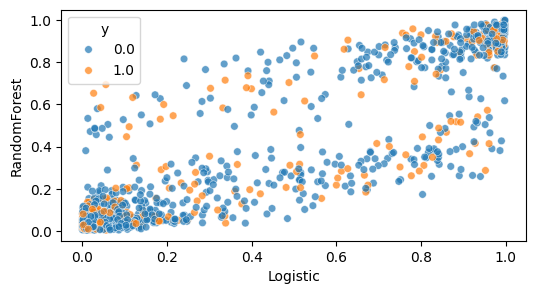

In [25]:
### a simple scatterplot

base_model_scatter = X_train_stacked.copy()
base_model_scatter['y'] = y_train

sns.scatterplot(data=base_model_scatter, x='Logistic', y='RandomForest', hue='y', alpha = 0.7, s=30)
plt.show()

### Logit transform the stacked model

The evaluations of the models are expressed as probabilities, so in $[0,1]$. We want to transform them into log-odd ratios to $[-\infty,\infty]$ via the logit function

In [26]:
def logit(X):
    epsilon = 1e-6
    X_clipped = np.clip(X, epsilon, 1 - epsilon)
    return np.log(X_clipped / (1 - X_clipped))

In [27]:
X_train_stacked_logodd = X_train_stacked.apply(logit)
X_test_stacked_logodd = X_test_stacked.apply(logit)

### Train the meta model

In [28]:
from sklearn.naive_bayes import GaussianNB

meta_classifier = GaussianNB()

meta_classifier.fit(X_train_stacked_logodd,y_train)

GaussianNB()

### Evaluate the meta model

In [73]:
results_test_models_list_meta = results_test_models_list.copy()


y_pred = meta_classifier.predict(X_test_stacked_logodd)

results_test = {
    "model": "meta",
    "accuracy": accuracy_score(y_test,y_pred),
    "recall": recall_score(y_test,y_pred),
    "selectivity": recall_score(y_test,y_pred,pos_label = 0),
    "f1": f1_score(y_test,y_pred),
    "f3": fbeta_score(y_test,y_pred,beta = 3),
    "precision": precision_score(y_test,y_pred),
    "NPV": precision_score(y_test,y_pred, pos_label = 0)
}

results_test_models_list_meta.append(results_test)

results_test_models_df_meta = pd.DataFrame(results_test_models_list_meta)

In [82]:
y_pred_test_meta = y_pred

In [84]:
y_pred_test_meta

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

In [75]:
results_test_models_df_meta

,model,accuracy,recall,selectivity,f1,f3,precision,NPV
0,Logistic,0.894860,0.807692,0.922840,0.788732,0.803828,0.770642,0.937304
1,RandomForest,0.897196,0.817308,0.922840,0.794393,0.812620,0.772727,0.940252
2,Knearestneighbors,0.801402,0.605769,0.864198,0.597156,0.604027,0.588785,0.872274
3,meta,0.873832,0.836538,0.885802,0.763158,0.820755,0.701613,0.944079


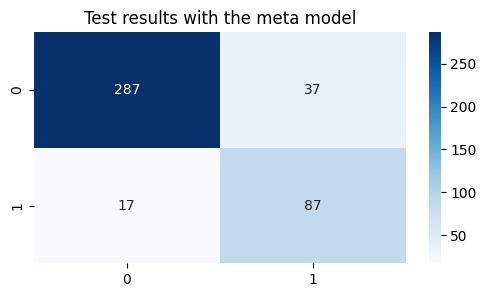

In [32]:
sns.heatmap(confusion_matrix(y_test,y_pred_test_meta), annot = True, cmap = "Blues", fmt='d')
plt.title("Test results with the meta model")
plt.show()

## Case study patient 2023

A 23 year old male, 63kg, hemo, offtrt, time censored 240, 1 anno e 6 mesi, trt2.

In [61]:
sorted(y_test.index)

[2,
 9,
 13,
 15,
 18,
 21,
 23,
 28,
 34,
 35,
 37,
 42,
 46,
 53,
 56,
 60,
 64,
 69,
 76,
 87,
 98,
 99,
 106,
 116,
 121,
 125,
 128,
 134,
 144,
 153,
 154,
 155,
 165,
 168,
 171,
 173,
 182,
 186,
 193,
 195,
 197,
 207,
 208,
 215,
 238,
 239,
 241,
 251,
 254,
 256,
 257,
 262,
 263,
 264,
 269,
 274,
 278,
 279,
 286,
 291,
 295,
 306,
 311,
 317,
 318,
 327,
 339,
 344,
 350,
 352,
 357,
 359,
 365,
 370,
 375,
 377,
 380,
 404,
 407,
 409,
 414,
 427,
 434,
 436,
 443,
 445,
 488,
 489,
 495,
 498,
 501,
 506,
 507,
 513,
 517,
 519,
 521,
 522,
 524,
 528,
 540,
 563,
 568,
 573,
 584,
 588,
 591,
 597,
 601,
 610,
 613,
 616,
 618,
 624,
 630,
 631,
 637,
 643,
 655,
 664,
 665,
 666,
 667,
 677,
 681,
 696,
 701,
 703,
 704,
 722,
 730,
 735,
 739,
 740,
 741,
 743,
 762,
 774,
 782,
 783,
 786,
 788,
 789,
 796,
 809,
 815,
 817,
 829,
 831,
 835,
 838,
 843,
 850,
 852,
 853,
 856,
 859,
 861,
 862,
 864,
 873,
 880,
 884,
 894,
 905,
 907,
 908,
 910,
 913,
 915,
 928

In [62]:
id = 99

In [63]:
patient = pd.DataFrame(X_test.loc[id]).T
patient

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,race,...,offtrt,cd40,cd420,cd80,cd820,time730,time_censored,trt0,trt1,trt2
99,33.0,83.4624,0.0,1.0,0.0,100.0,0.0,1.0,306.0,0.0,...,0.0,272.0,257.0,842.0,758.0,147.0,0.0,0.0,1.0,0.0


In [64]:
y_test.loc[id]

np.int64(1)

In [76]:
X_test_stacked_indexed = X_test_stacked.copy()
X_test_stacked_indexed.index = X_test.index
X_test_stacked_logodd_indexed = X_test_stacked_logodd.copy()
X_test_stacked_logodd_indexed.index = X_test.index

In [108]:
for i in range(len(y_test)):
    id = y_test.index[i]
    patient = pd.DataFrame(X_test.loc[id]).T
    patient_stack = pd.DataFrame(X_test_stacked_indexed.loc[id]).T
    patient_stack
    patient_stack_logodd = pd.DataFrame(X_test_stacked_logodd_indexed.loc[id]).T

    prob = meta_classifier.predict_proba(patient_stack_logodd)
    pred = meta_classifier.predict(patient_stack_logodd)
    ytrue = y_test.loc[id]  

    knn_pred = patient_stack['Knearestneighbors'].iloc[0]
    log_pred = patient_stack['Logistic'].iloc[0]
    rf_pred = patient_stack['RandomForest'].iloc[0]

    if knn_pred > 0.5 and log_pred > 0.5 and rf_pred < 0.5 and ytrue > 0.5:
        print(i, id)
        print(patient)
        print(patient_stack)
        print(prob, pred, ytrue)

308 1942
       age  wtkg  hemo  homo  drugs  karnof  oprior  z30  preanti  race  ...  \
1942  30.0  75.9   0.0   1.0    0.0   100.0     0.0  0.0      0.0   0.0  ...   

      offtrt   cd40  cd420   cd80  cd820  time730  time_censored  trt0  trt1  \
1942     1.0  580.0  343.0  950.0  874.0      0.0          318.0   0.0   1.0   

      trt2  
1942   0.0  

[1 rows x 24 columns]
      Logistic  RandomForest  Knearestneighbors
1942  0.770323      0.423282                1.0
[[0.01409062 0.98590938]] [1] 1


array([[0.00971186, 0.99028814]])

In [67]:
meta_classifier.predict(patient_stack)

array([1])

## Visualize decision boundary with two base models

In [211]:
# let's boundary plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_decision_boundary(fitted_meta_model, Xstackedtrain, ytrain, figsize = (10,6)):
    """
    np2darray.ravel() efficiently flattens the array
    np.c_ is like clumn_stack: it acts as zip(), into a 2d array
    """
    df = Xstackedtrain.copy()
    df['y'] = ytrain

    # Create a meshgrid of points
    ## xx.shape == (M,N) where M,N are the number of gridpoints nd the X/Y axis respectively
    x_min, x_max, y_min, y_max = -11, 7.5, -7, 7
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

    ## xx.ravel().shape == (M*N,)
    ## xy.shape = (M*N,2)
    xy = np.c_[xx.ravel(), yy.ravel()]   
    xy = pd.DataFrame(xy,columns = models.keys())  
    
    # Predict on the grid
    Z = meta_classifier.predict(xy)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=figsize)
    ## scatterplot the base model predictions
    sns.scatterplot(data=df, x='Logistic', y='RandomForest', hue='y', s= 30, alpha = 0.6)
    ## countrouf the meta model prediction
    plt.contourf(xx, yy, Z, alpha=0.2, levels=1)
    plt.title("Decision boundary of the meta model")
    plt.show()

In [212]:
#plot_decision_boundary(meta_classifier, X_train_stacked_logodd, y_train)


## Vanilla models

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier




In [214]:
'''models_vanilla = {}
models_vanilla["LogisticRegression"] = LogisticRegression(random_state=42)
models_vanilla["DecisionTree"] = DecisionTreeClassifier(random_state=42)
models_vanilla["RandomForest"] = RandomForestClassifier(random_state=42)
models_vanilla["KNearestNeighbors"] = KNeighborsClassifier()
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)'''

'models_vanilla = {}\nmodels_vanilla["LogisticRegression"] = LogisticRegression(random_state=42)\nmodels_vanilla["DecisionTree"] = DecisionTreeClassifier(random_state=42)\nmodels_vanilla["RandomForest"] = RandomForestClassifier(random_state=42)\nmodels_vanilla["KNearestNeighbors"] = KNeighborsClassifier()\nmodels_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)'

In [215]:
models_vanilla = {}
models_vanilla["RandomForest"] =models["RandomForest"]
models_vanilla["KNearestNeighbors"] = models["Knearestneighbors"]
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)

In [216]:
from src.model_selection import cv_accuracy_recall

In [217]:
cv_vanilla = []
for modelname in models_vanilla:
    cv_vanilla.append(cv_accuracy_recall(X_train_scaled,y_train_, models_vanilla[modelname], modelname + "_vanilla"))
cv_vanilla = pd.DataFrame(cv_vanilla)
cv_vanilla

,accuracy,recall,model
0,0.878426,0.692943,RandomForest_vanilla
1,0.829918,0.491538,KNearestNeighbors_vanilla
2,0.877841,0.721773,ArtificialNeuralNetworkMLP_vanilla


### Undersampled training vanilla

In [218]:
models_vanilla = {}
models_vanilla["LogisticRegression"] = LogisticRegression(random_state=42)
models_vanilla["DecisionTree"] = DecisionTreeClassifier(random_state=42)
models_vanilla["RandomForest"] = RandomForestClassifier(random_state=42)
models_vanilla["KNearestNeighbors"] = KNeighborsClassifier()
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)

In [219]:
models_vanilla = {}
models_vanilla["RandomForest"] =models["RandomForest"]
models_vanilla["KNearestNeighbors"] = models["Knearestneighbors"]
models_vanilla["ArtificialNeuralNetworkMLP"] = MLPClassifier(random_state=42)

In [220]:
models

{'Logistic': LogisticRegression(random_state=42),
 'RandomForest': RandomForestClassifier(min_samples_leaf=2, n_estimators=500),
 'Knearestneighbors': KNeighborsClassifier(metric='manhattan', n_neighbors=3)}

In [221]:
def sample_balance_Xy(X,y, with_reindex = False):
    df = X.copy()
    df['infected'] = y
    df_infected = df[df['infected']==1] 
    df_not_infected = df[df['infected']==0]

    num_infected = df_infected.shape[0]
    df_sample_not_infected = df_not_infected.sample(num_infected, random_state=42)

    df_balanced = pd.concat([df_infected,df_sample_not_infected])
    # we shuffle it once more at the end.
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    if with_reindex:
        df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    else:
        df_balanced = df_balanced.sample(frac=1)
    X_balanced = df_balanced.drop(columns=['infected'])
    y_balanced = df_balanced['infected']
    return X_balanced,y_balanced


In [222]:
X_train_balanced, y_train_balanced = sample_balance_Xy(X_train_scaled, y_train_)

In [223]:
X_train_balanced.shape

(676, 24)

In [224]:
cv_vanilla_balanced = []
for modelname in models_vanilla:
    cv_vanilla_balanced.append(cv_accuracy_recall(X_train_balanced,y_train_balanced, models_vanilla[modelname], modelname + "_balanced"))
cv_vanilla_balanced = pd.DataFrame(cv_vanilla_balanced)
cv_vanilla_balanced

,accuracy,recall,model
0,0.488137,0.484987,RandomForest_balanced
1,0.489651,0.479368,KNearestNeighbors_balanced
2,0.519270,0.541440,ArtificialNeuralNetworkMLP_balanced


## Oversampling vanilla

In [225]:
from imblearn.over_sampling import SMOTENC


In [226]:
from imblearn.pipeline import Pipeline, make_pipeline

cat_features = [c for c in X_train_ if X_train_[c].nunique() < 5]
smote_nc =  SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)




In [227]:
cv_vanilla_smote = []
for modelname in models_vanilla:
    model = models_vanilla[modelname]
    X_ = X_train_scaled.copy()
    y_ = y_train_
    imba_pipeline = make_pipeline(smote_nc, model)
    cv_vanilla_smote.append(cv_accuracy_recall(X_,y_, imba_pipeline, modelname + "_smote"))
cv_vanilla_smote = pd.DataFrame(cv_vanilla_smote)
cv_vanilla_smote

c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTENC or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTENC or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. Fro

,accuracy,recall,model
0,0.875507,0.793718,RandomForest_smote
1,0.805364,0.659409,KNearestNeighbors_smote
2,0.866150,0.743259,ArtificialNeuralNetworkMLP_smote


In [228]:
all_cv = pd.concat([cv_vanilla,cv_vanilla_smote])
all_cv

,accuracy,recall,model
0,0.878426,0.692943,RandomForest_vanilla
1,0.829918,0.491538,KNearestNeighbors_vanilla
2,0.877841,0.721773,ArtificialNeuralNetworkMLP_vanilla
0,0.875507,0.793718,RandomForest_smote
1,0.805364,0.659409,KNearestNeighbors_smote
2,0.866150,0.743259,ArtificialNeuralNetworkMLP_smote


In [229]:
def firstme(word):
    return word.split("_")[0]

all_cv["model_base"] = all_cv["model"].apply(firstme)
all_cv

,accuracy,recall,model,model_base
0,0.878426,0.692943,RandomForest_vanilla,RandomForest
1,0.829918,0.491538,KNearestNeighbors_vanilla,KNearestNeighbors
2,0.877841,0.721773,ArtificialNeuralNetworkMLP_vanilla,ArtificialNeuralNetworkMLP
0,0.875507,0.793718,RandomForest_smote,RandomForest
1,0.805364,0.659409,KNearestNeighbors_smote,KNearestNeighbors
2,0.866150,0.743259,ArtificialNeuralNetworkMLP_smote,ArtificialNeuralNetworkMLP


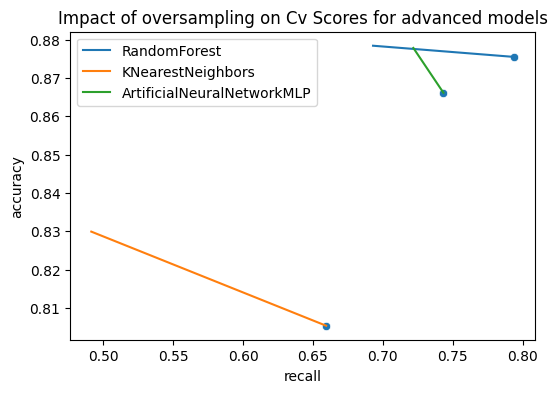

In [234]:
plt.figure(figsize = (6,4))
sns.lineplot(data = all_cv, x= "recall", y="accuracy",hue = "model_base")
sns.scatterplot(data=cv_vanilla_smote, x = "recall", y= "accuracy", legend = True)
plt.title("Impact of oversampling on Cv Scores for advanced models")
plt.show()